In [ ]:
#Taller Final David Báez - Andrés Ramirez.

In [ ]:
#Tema XI: Portafolio de Seguimiento.

**Introducción**

En el desarrollo de este trabajo se realizará el tracking de portafolio con base en un componente accionario tomado del índice DJI, con el objetivo de realizar el proceso de optimización usando las respectivas restricciones de cardinalidad. Finalmente, se utilizó la simulación de Monte Carlo, con el objetivo de poder analizar los riesgos del portafolio generado. 

**¿Qué es el Tracking Error?**

Este es un elemento de análisis que se emplea para evaluar los rendiminetos de un fondo, con respecto a un benchmark de referencia, es decir, con el índice utilizado para comparar los rendimientos del portafolio construido. Los fondos que emplean esta herramienta lo hacen para contrastar los resultados de su gestión, por lo que si los rendimientos del portafolio que generaron son positivos, el Tracking Error será alto, teniendo en cuenta que va a tener un resultado superior a la rentadbilidad del índice. No obstante, si la gestión del fondo no es apropiaba, el Tracking Error mostrará que la rentabilidad del portafolio es inferior al benchmark seleccionado. 

Teniendo en cuenta lo anterior, se buscará poder realizar un análisis descriptivo, que se sustente en un elemento gráfico que permita observar la cercania del portafolio generado, respecto al índice mencionado anteriormente. 

In [ ]:
#A continuación se presenta el desarrollo del código para poder resolver la temática planteada. 

In [1]:
#En primer lugar, se importan las librerias que se utilizarán para el desarrollo del código. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy import stats
from scipy.stats import norm
!pip install --quiet yfinance
import yfinance as yf

In [2]:
#Teniendo en cuenta que se seleccionó el índice DJI, se descargan sus precios y retornos para los cinco años establecidos. 
#Se seleccionó este índice, ya que contiene las 30 empresas que cuentan con mayor capitalización bursatil de la Bolsa de New York.
dji = yf.download("^DJI", period='5y')['Adj Close']
dji_returns = dji.pct_change().dropna()
dji_returns.mean()

[*********************100%***********************]  1 of 1 completed


0.0003306871505364766

In [3]:
#Ahora, para hacer el respectivo tracking se extraen una parte de las acciones del índice que tentativamente cumplirán las restricciones de cardinalidad que se plantearán. 
#Una vez seleccionados, se procede a traer la información referente a los precios de las acciones. 
# Descargar los precios de acciones que podrian cumplir los requerimientos de cardinalidad 
Acciones = [ "AAPL","NKE","KO","JPM","INTC", "JNJ", "MSFT","PG", "UNH","V","MCD","MRK","MMM"]
data = yf.download(Acciones, period='5y')['Adj Close']
returns = data.pct_change().dropna()
n = len(Acciones)
benchmark_weights = np.ones(n) / n
mu = returns.mean()
cov = returns.cov()
sigma = returns.std()

[*********************100%***********************]  13 of 13 completed


In [ ]:
#En el siguiente frame se define la función que permitirá establecer las restricciones de cardinalidad.
#Las restricciones consisten en que: 1) Suma de pesos igual a 1, 2) Los pesos deben ser mayores o iguales a 0 3). n<k -n=k

In [4]:
def build_tracking_portfolio(returns, benchmark_weights, cardinality):
    n = len(returns.columns)
    x = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(x - benchmark_weights, np.cov(returns.T)))
    constraints = [cp.sum(x) == 1] # Restricción de suma de pesos igual a 1
    constraints += [cp.sum(cp.abs(x)) <= cardinality] # Restricción de cardinalidad
    problem = cp.Problem(objective, constraints)
    problem.solve()
    weights = x.value
    return weights

In [5]:
#Con esta definición realizada, se procede a calcular el trackingm tomando 13 acciones del índice. 
cardinality = 13 
tracking_portfolio = build_tracking_portfolio(returns, benchmark_weights, cardinality)
print("El tracking portfolio es", tracking_portfolio, sep='\n')

El tracking portfolio es
[0.07692307 0.07692308 0.07692302 0.07692308 0.07692308 0.07692305
 0.07692309 0.0769231  0.07692308 0.07692308 0.07692312 0.07692309
 0.07692309]


In [6]:
#Se calculan los retornos del tracking realizado en el siguiente apartado. 
tracking_returns = np.dot(returns, tracking_portfolio)
tracking_cumulative_returns = (1 + tracking_returns).cumprod()
dji_cumulative_returns = (1 + dji_returns).cumprod()

In [7]:
#Defino la información al interior de un DataFrame para posteriormente poder realizar su gráfica. 
Tracking = pd.DataFrame({'Tracking Portfolio': tracking_cumulative_returns, 'DJI': dji_cumulative_returns})

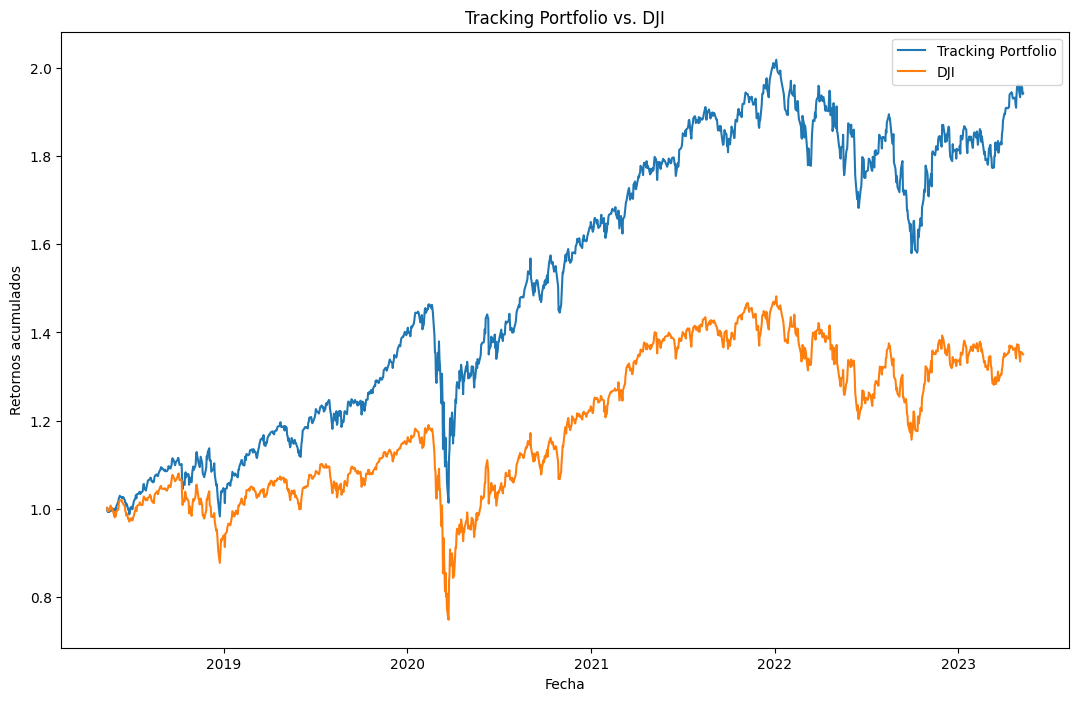

In [8]:
#Procedemos a realizar la gráfica del tracking realizado, con respecto al índice DJI
plt.figure(figsize=(13, 8))
plt.plot(Tracking)
plt.legend(Tracking.columns)
plt.title('Tracking Portfolio vs. DJI')
plt.xlabel('Fecha')
plt.ylabel('Retornos acumulados')
plt.show()

Análisis 

En el resultado del Plot, se puede observar que el comportaminto del tracking de portafolio que se generó es similar al del índice, ya que tiene sus respectivos crecimientos en los retornos, en los años 2019 y 2021-2022 (post-pandemia), junto con sus respectivos decrecimientos en 2020, por la pandemia y en en final del año 2022, que constituye el cambio en el ciclo económico en el mundo. 

In [13]:
# Usamos CVXPY para encontrar el portafolio óptimo de Sharpe.
x = cp.Variable(n)
objetivo = cp.Minimize(cp.quad_form(x, cov))
restricciones = [x @ mu == 1, x >= 0]
prob = cp.Problem(objetivo, restricciones)
prob.solve()
wpt = x.value/x.value.sum()

In [14]:
#Se procede a calcular el retorno del portafolio, junto con su volatilidad (sigma)
ret_port = returns @ wpt
rpt = ret_port.mean()
sigmapt = ret_port.std()
print('Retorno esperado: ', rpt.round(4))
print('Volatilidad: ', sigmapt.round(4))

Retorno esperado:  0.001
Volatilidad:  0.0127


In [11]:
#Se procede a crear la muestra simulada con retornos, teniendo en cuenta una distribución normal, por lo que se crean 10.000 portafolios aleatorios.
#Posteriormente, se toman sus retornos, junto con su volatilidad.

n_port = 10000                                 
ma_pt = np.random.normal(rpt,sigmapt, n_port)  

In [12]:
ma_pt

array([ 0.01211925,  0.01841496, -0.005354  , ..., -0.01138727,
       -0.0073843 , -0.0081148 ])

Bibliografía 

Estrategías de Inversión. (2023). ¿Qué es el Tracking Error? Recuperado de:https://www.estrategiasdeinversion.com/herramientas/diccionario/mercados/tracking-error-t-1709  